# Support Vector Machine — Model Training & Hyperparameter Optimization

This notebook trains and tunes a Support Vector Machine (SVC) for predicting obesity category using the training set.  
All preprocessing is embedded inside a scikit-learn pipeline to avoid data leakage.

**Dataset used:** `train_set.csv`  
**Target:** `NObeyesdad`  
**Task:** Multiclass Classification  
**Metrics:** Accuracy, F1-macro  
**CV Strategy:** StratifiedKFold (5 folds)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

RANDOM_STATE = 42

# Load Training Data
df = pd.read_csv("../../data/train_set.csv")

target = "NObeyesdad"
X = df.drop(columns=[target])
y = df[target]

# Secondary Test/Train Split
X_train, X_test_internal, y_train, y_test_internal = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

# Identify Numeric and Categorical Features
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object", "bool"]).columns.tolist()

# Preprocessing Pipeline
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# SVM Pipeline
svm_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("svm", SVC(random_state=RANDOM_STATE))
])

# Hyperparameter Grid
param_grid = {
    "svm__kernel": ["linear", "rbf"],
    "svm__C": [0.1, 1, 5, 10],
    "svm__gamma": ["scale", "auto"]
}

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Grid Search CV for Hyperparameter Tuning
grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
best_params = grid.best_params_

print("\nBest Parameters:", best_params)

# Secondary Test Set Evaluation
y_pred_internal = best_svm.predict(X_test_internal)

internal_acc = accuracy_score(y_test_internal, y_pred_internal)
internal_f1 = f1_score(y_test_internal, y_pred_internal, average="macro")

print("\nSecondary Test Accuracy:", internal_acc)
print("Secondary Test F1 Score:", internal_f1)

# Cross-Validation Results DataFrame
cv_results = pd.DataFrame(grid.cv_results_)[
    ["params", "mean_test_score", "std_test_score"]
].sort_values(by="mean_test_score", ascending=False)

cv_results.head()


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}

Internal Test Accuracy: 0.9585798816568047
Internal Test F1 Score: 0.9589486292585744


,params,mean_test_score,std_test_score
12,"{'svm__C': 10, 'svm__gamma': 'scale', 'svm__ke...",0.963336,0.008903
14,"{'svm__C': 10, 'svm__gamma': 'auto', 'svm__ker...",0.963336,0.008903
8,"{'svm__C': 5, 'svm__gamma': 'scale', 'svm__ker...",0.955455,0.010368
10,"{'svm__C': 5, 'svm__gamma': 'auto', 'svm__kern...",0.955455,0.010368
15,"{'svm__C': 10, 'svm__gamma': 'auto', 'svm__ker...",0.942121,0.011031


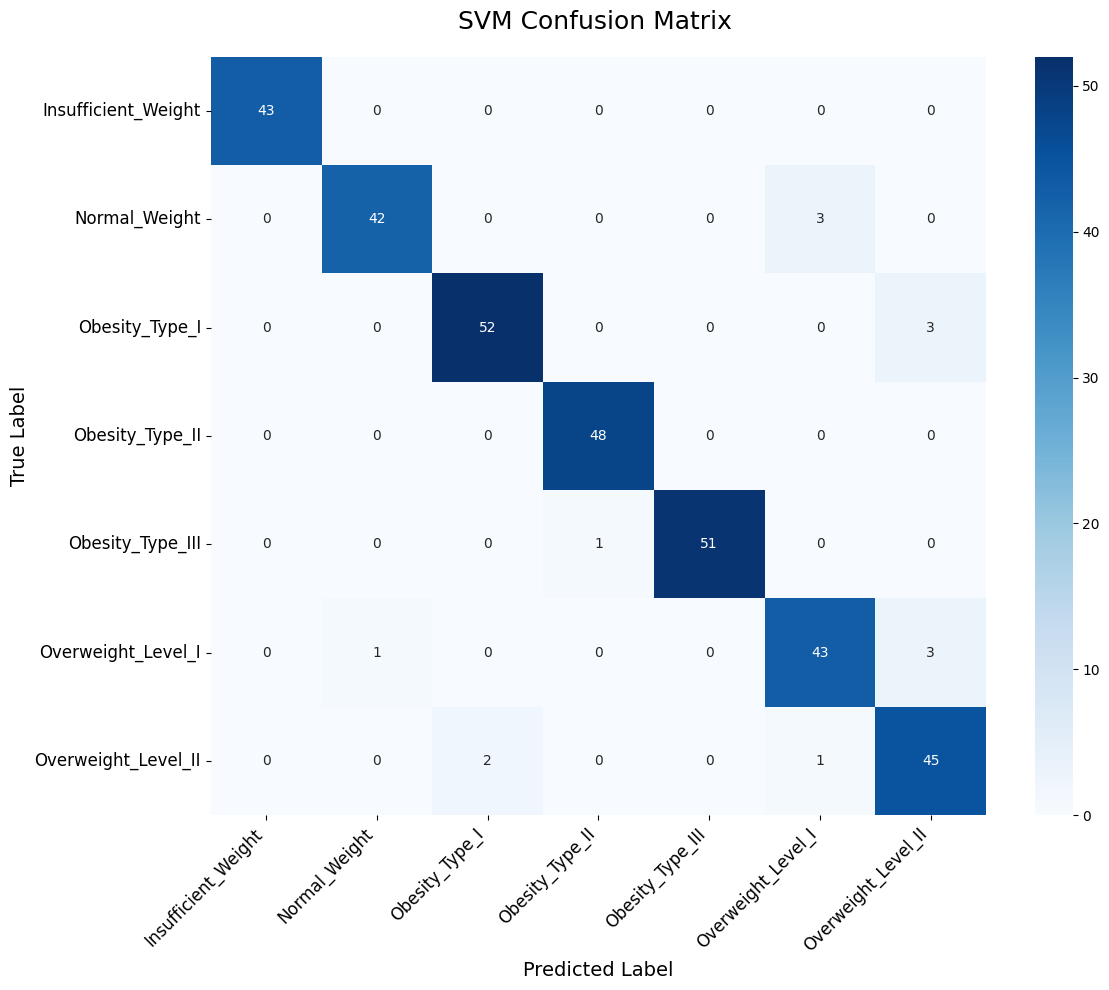

Saved svm_confusion_matrix.png to OUTPUT folder.


In [4]:
# Confusion Matrix plot
cm = confusion_matrix(y_test_internal, y_pred_internal)
labels = sorted(y_test_internal.unique())  # or use svm_label_encoder.classes_

plt.figure(figsize=(12, 10))

# Plotting the Heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

# Customizing the Plot
plt.title("SVM Confusion Matrix ", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()

# Save the matrix to OUTPUT folder
os.makedirs("../../OUTPUT", exist_ok=True)
plt.savefig("../../OUTPUT/svm_confusion_matrix.png", dpi=300)

plt.show()

print("Saved svm_confusion_matrix.png to OUTPUT folder.")
